In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
import time
from collections import Counter
from wordcloud import WordCloud
from matplotlib.font_manager import FontProperties

import folium
from folium.plugins import HeatMap
from geopy.geocoders import Nominatim

In [2]:
!pip install -q pythainlp
from pythainlp.tokenize import word_tokenize
from pythainlp.corpus import thai_stopwords

from transformers import AutoTokenizer
from transformers import AutoModelForTokenClassification
import torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.9/17.9 MB 18.3 MB/s eta 0:00:00


In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/tweets.csv')
# df.drop(columns='Time', inplace=True)
print(df.shape)
df.head()

(926, 1)


,Tweet
0,ไปเที่ยวกับพี่ไม่มีอ่อม! กลับมาครั้งยิ่งใหญ่ ...
1,20:17 #อุบัติเหตุ #ถนนมอเตอร์เวย์ ช่วง ด่านเก็...
2,19:53 #ถนนรัชดาท่าพระ ช่วง แยกรัชดาตลาดพลู >แย...
3,18:58 #อุบัติเหตุ #ถนนกาญจนาภิเษก ช่วง ต่างระด...
4,18:55 #อุบัติเหตุ #ถนนมอเตอร์เวย์ (ช่วง แยกพัท...


In [5]:
def filter_accident_tweet(df):
  accident_idx = []
  for i, tweet in enumerate(df['Tweet']):
    if 'เหตุ' in tweet:
      accident_idx.append(i)

  return df.loc[accident_idx].reset_index(drop=True)


filtered_df = filter_accident_tweet(df)

## EDA

1. Top 10 hashtag

In [6]:
def extract_location_and_incident(text):
    words = text.split()
    hashtags = [word for word in words if word.startswith('#')]
    return hashtags

all_hashtags = df['Tweet'].apply(extract_location_and_incident).sum()
hashtag_frequency = Counter(all_hashtags)
hashtag_frequency = pd.DataFrame(hashtag_frequency.items(), columns=['Hashtag', 'Frequency'])\
                          .sort_values(by='Frequency', ascending=False)

hashtag_frequency.head(10)

,Hashtag,Frequency
3,#รถติด,340
1,#อุบัติเหตุ,281
15,#ข่าวPNC,77
13,#JS100,52
18,#ฝนตก,29
5,#ถนนกาญจนาภิเษก,28
23,#ถนนพหลโยธิน,25
31,#ถนนพระราม2,23
9,#ถนนจรัญสนิทวงศ์,16
2,#ถนนมอเตอร์เวย์,15


2. WordCloud

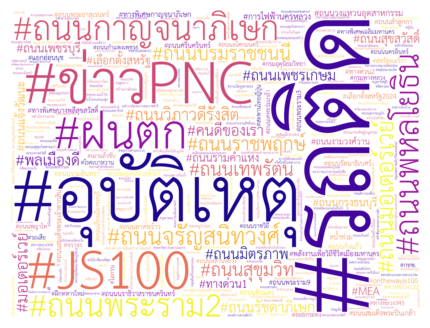

In [7]:
hashtag_freq_dict = hashtag_frequency.set_index('Hashtag')['Frequency'].to_dict()
wordcloud = WordCloud(
                      font_path='/content/drive/MyDrive/THSarabunNew.ttf',
                      relative_scaling = 0.3,
                      min_font_size=1,
                      background_color="white",
                      width=1024,
                      height=768,
                      max_words=2000,
                      colormap='plasma',
                      scale=3,
                      font_step=4,
                      collocations=False,
                      regexp=r"[ก-๙a-zA-Z']+",
                      margin=2
                      ).generate_from_frequencies(hashtag_freq_dict)

plt.figure(figsize=(6, 4))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

3. Bar Chart

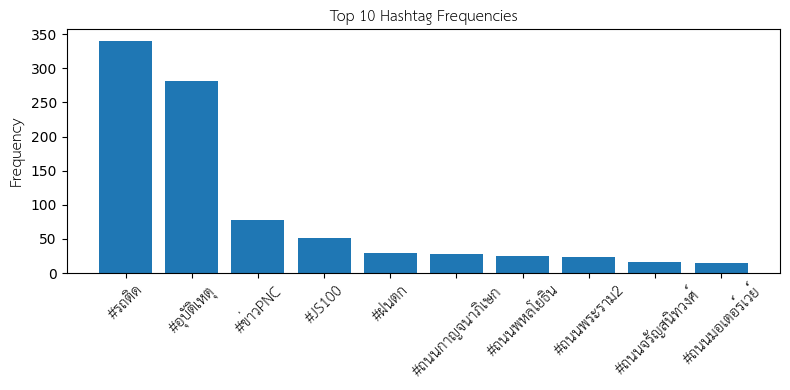

In [8]:
top10_hashtag = hashtag_frequency.sort_values(by='Frequency', ascending=False).head(10)
font_prop = FontProperties(fname='/content/drive/MyDrive/THSarabunNew.ttf', size=16)

plt.figure(figsize=(8, 4))
plt.bar(top10_hashtag['Hashtag'], top10_hashtag['Frequency'])
plt.xticks(rotation=45, fontproperties=font_prop)  # Rotate x-axis labels
plt.ylabel('Frequency', fontproperties=font_prop)
plt.title('Top 10 Hashtag Frequencies', fontproperties=font_prop)
plt.tight_layout()
plt.show()

## Preprocessing

### 1. Hashtag tweet
- filter by hashtag order

In [9]:
location, start, end = [], {}, {}

# extract the area of incident if sentence has pattern <start> > <end>
def extract_location(words):
  for ind, word in enumerate(words):
      if word.startswith('>'):
        # print(f'start: {words[ind - 1]}  end: {word.replace(">", "")}')
        start[i] = words[ind - 1]
        end[i] = word.replace('>', '')
        break

In [10]:
for i, text in enumerate(filtered_df['Tweet']):
  words = text.split()

  hashtag = [word for word in words if word.startswith('#')]

  if '#อุบัติเหตุ' in hashtag:
    try:
      # print(f'location {i}: {hashtag[1]}')
      location.append(hashtag[1].replace('#', ''))
    except:
      filtered_df.drop(index=i, inplace=True)
  filtered_df.reset_index(drop=True, inplace=True)

  extract_location(words)

In [11]:
hashtag_df = pd.DataFrame(columns=['location', 'start', 'end'])
hashtag_df['location'] = location
hashtag_df['start'] = start
hashtag_df['end'] = end
hashtag_df.fillna('-', inplace=True)

hashtag_df.sample(10)

,location,start,end
238,ถนนสมเด็จพระเจ้าตากสิน,-,-
244,ทางหลวง345,แยกเพชรพระราม,แยกราชเทวี
53,ถนนกาญจนาภิเษก,ช่วงแยกรัชดาลาดพร้าว,สะพานข้ามคลองลาดพร้าว
213,รถติด,แยกซ.เจริญใจ,แยกเอกมัยตัดสุขุมวิท
221,ถนนพญาไท,สะพานพระราม7,แยกบางพลัด
67,อุบัติเหตุ,หมู่บ้านปาริชาติ,ต่างระดับคลองข่อย
25,ซอยรามอินทรา8,ช่วงแยกแกลง,แยกทางเกวียน
211,ถนนจันทน์,มิตรสัมพันธ์,แยกนานา
198,ถนนนิมิตรใหม่,ช่วงแยกคลองเก้า,ต่างระดับกิ่งแก้ว
9,ถนนจรัญสนิทวงศ์,แยกบางพลัด,สะพานพระราม7


### 2. Non-Hashtag tweet

**Approach 1:** filter from regex (hard-coding)

In [12]:
def extract_location_regex(tweet):
    location_pattern = r"(ถนน\s?[^\s,]*)|(แยก\s?[^\s,]*)|(สะพาน\s?[^\s,]*)|(ซอย\s?[^\s,]*)|(ทางหลวง\s?[^\s,]*)"
    matches = re.findall(location_pattern, tweet)

    locations = []
    for match in matches:
        for loc in match:
            if loc:
                if loc.endswith(")") and "(" not in loc[:-1]:
                    loc = loc[:-1]  # Remove ')' if it's at the end but not part of the word
                locations.append(loc)
    return ", ".join(locations)


df['Tweet'].apply(extract_location_regex).sample(10)

,Tweet
423,
627,"ถนนเพชรบุรี, แยกเพชรพระราม, แยกราชเทวี"
710,
406,
270,
421,ถนนเทพรัตน
552,"ถนนราชพฤกษ์, แยกบางกรวยไทรน้อย, สะพานข้ามคลองอ..."
265,ถนนเทพรัตน
202,
490,


**Approach 2:** use thaiNER from pyThaiNLP package

In [13]:
def clean_text(text):
  text = re.compile(r'[/(){}\[\]\|@,;#+_\n]|น\.').sub('', text)
  text = text.replace('jsradio', '')

  return text

In [14]:
idx = [i for i, tweet in enumerate(filtered_df['Tweet']) if '#' in tweet]
th_stopwords = thai_stopwords()

no_hashtag_df = filtered_df.drop(index=idx)
no_hashtag_df['Tweet'] = no_hashtag_df['Tweet'].apply(clean_text)
no_hashtag_df.reset_index(drop=True, inplace=True)

In [15]:
name="pythainlp/thainer-corpus-v2-base-model"
tokenizer = AutoTokenizer.from_pretrained(name)
model = AutoModelForTokenClassification.from_pretrained(name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/550 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/905k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.18M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.27k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/419M [00:00<?, ?B/s]

In [16]:
def fix_span_error(words,ner):
    _ner = []
    _ner = ner
    _new_tag = []
    for i, j in zip(words,_ner):
        #print(i,j)
        i = tokenizer.decode(i)
        if i.isspace() and j.startswith("B-"):
            j = "O"
        if i == '' or i == '<s>' or i == '</s>':
            continue
        if i == "<_>":
            i = " "
        _new_tag.append((i,j))
    return _new_tag

def extract_ner(sentence):
    # Tokenization
    cut = word_tokenize(sentence.replace(" ", "<_>"))
    inputs = tokenizer(cut, is_split_into_words=True, return_tensors="pt")

    # fit into model
    ids = inputs["input_ids"]
    mask = inputs["attention_mask"]
    outputs = model(ids, attention_mask=mask)  # forward pass

    predictions = torch.argmax(outputs[0], dim=2)
    predicted_token_class = [model.config.id2label[t.item()] for t in predictions[0]]

    ner = fix_span_error(inputs['input_ids'][0], predicted_token_class)

    # filter the LOCATION
    ner_list = [word if 'LOCATION' in tag else ' ' for word, tag in ner]

    return ''.join(ner_list).strip()

In [17]:
no_hashtag_df['candidates_loc'] = no_hashtag_df['Tweet'].apply(extract_ner)
no_hashtag_df['candidates_loc'] = no_hashtag_df['candidates_loc'].apply(lambda x: x.split())

In [18]:
def filter_location(loc):
  # remove one character in list e.g. 'ม'
  loc = [x for x in loc if len(x) > 3 or x.isnumeric() or x == 'สาย' or x == 'แยก']

  for i, word in enumerate(loc):
    if word.isnumeric() and i != 0:
      return ''.join(loc[:i+1])
      break
    elif word.isnumeric() and i == 0:
      loc.remove(word)
      continue
    elif 'ถนน' in word or 'ถ.' in word:
      return word

  return loc[0]


no_hashtag_df['location'] = no_hashtag_df['candidates_loc'].apply(filter_location)

## Text classification model for accident case

In [19]:
def clean_ner_word(df):
  for i, tweet in enumerate(df['Tweet']):
    for word in df.loc[i, 'candidates_loc']:
      tweet = tweet.replace(word, '')

    df.loc[i, 'Tweet'] = tweet

  df['Tweet'] = df['Tweet'].apply(lambda x: re.compile(r'[0-9]').sub('', x))

In [20]:
accident_idx = df[ (df['Tweet'].str.contains('รถติด|อุบัติเหตุ')) ].index

# Data preparation
train_df = df.copy()
train_df['Accident'] = 0
train_df.loc[accident_idx, 'Accident'] = 1

# Preprocessing
train_df['candidates_loc'] = train_df['Tweet'].apply(extract_ner)
train_df['candidates_loc'] = train_df['candidates_loc'].apply(lambda x: x.split())
clean_ner_word(train_df)

**Training Model**

In [21]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

In [22]:
pd.crosstab(train_df['Accident'], 'count')

col_0,count
Accident,
0,456
1,470


In [23]:
# Prepare the data for training
sample_df = train_df.sample(500)
X = sample_df['Tweet'].values
y = sample_df['Accident'].values

# Data Preparation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tokenizer = Tokenizer(num_words=500)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_sequence_length = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_length)

# Building model
model = Sequential()
model.add(Embedding(2000, 64, input_length=max_sequence_length))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# Training model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_data=(X_test_pad, y_test))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.5595 - loss: 0.6835 - val_accuracy: 0.9000 - val_loss: 0.6316
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9051 - loss: 0.6004 - val_accuracy: 0.8800 - val_loss: 0.4632
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.9114 - loss: 0.3920 - val_accuracy: 0.8900 - val_loss: 0.3187
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9182 - loss: 0.2749 - val_accuracy: 0.9200 - val_loss: 0.2464
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.9462 - loss: 0.1953 - val_accuracy: 0.9300 - val_loss: 0.1918
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.9507 - loss: 0.1533 - val_accuracy: 0.9300 - val_loss: 0.1723
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.9623 - loss: 0.1208 - val_accuracy: 0.9300 - val_loss: 0.1675
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.9632 - loss: 0.1122 - val_accuracy: 0.9300 - 

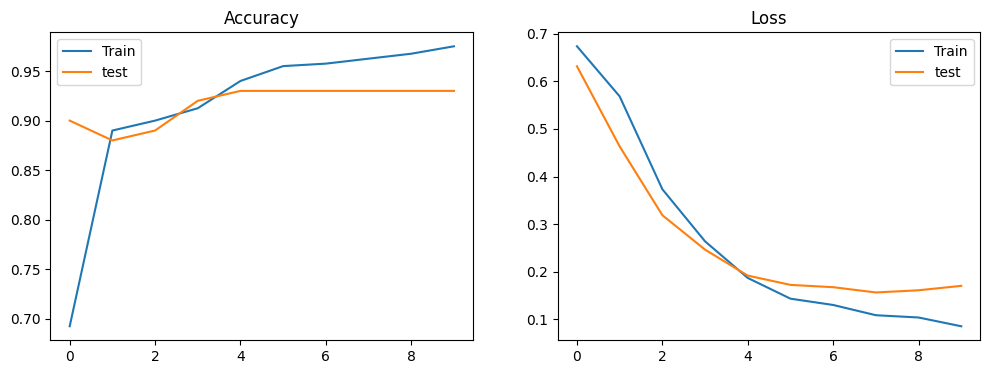

In [24]:
plt.subplots(1, 2, figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Loss')
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [37]:
predictions = model.predict(X_test_pad)
predictions = (predictions > 0.5).astype('int')

result = pd.DataFrame({'Tweet': X_test, 'Accident': predictions.flatten()})
result.sample(10)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


,Tweet,Accident
80,RT\n@sweetalice\n : # ขาเข้าจะ ท้ายแถวเชิงทาง ...,1
76,: น# ช่วง > เก็บเงิน \nที่กม+ มีงานซ่อมบำรุง ...,1
20,รู้ยัง!? - พ.ย. นี้ ไฟฟ้าดับพื้นที่ไหนบ้าง?\...,0
53,: #อุบัติเหตุ #ถนนรามคำแหง ช่วง >แยกรามคำแหง บ...,1
49,. น. #อุบัติเหตุ # ขาออก จาก > ที่ก่อนถึง เล็ก...,1
94,กระแสโซเชียล! วัยรุ่นจีน หมายหมื่น รวมตัวปั่นจ...,0
60,งานวัดภูเขาทอง ประเพณีห่มผ้าแดง ณ วัดสระเกศรา...,0
16,RT\n@SweetJiab\n ๑๗.๑๗ น. จะข้าม รถติดหนักมากค่ะ,0
89,ศาลให้ประกันสาวเมาแล้วขับย้อนศร ขึ้นทางด่วน - ...,0
34,GWM POER SAHAR ได้รับการรับรองมาตรฐานด้านความป...,0


Test with real tweet

In [61]:
seq_prep = tokenizer.texts_to_sequences(no_hashtag_df['Tweet'])
pad_prep = pad_sequences(seq_prep, maxlen=max_sequence_length)

pred = model.predict(pad_prep)
pred = (pred > 0.5).astype('int').flatten()
result = pd.DataFrame({'Predictions': pred.flatten()})
no_hashtag_df = pd.concat([no_hashtag_df, result], axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


## Map to geographical
interactive map: https://medium.com/@witchapongdaroontham/interactive-map-plot-with-bokeh-4afa77ad42c1

In [62]:
filter = (no_hashtag_df['Predictions'] == 1)
location = pd.concat([hashtag_df['location'], no_hashtag_df.loc[filter, 'location']], axis=0)
location_df = pd.DataFrame(location, columns=['location'])

In [63]:
geolocator = Nominatim(user_agent="location_mapper")
location_cache = {}

def get_coordinates(location_text, retries=3):
    # Check cache first
    if location_text in location_cache:
        return location_cache[location_text]

    for attempt in range(retries):
        try:
            location = geolocator.geocode(location_text)
            if location:
                coordinates = (location.latitude, location.longitude)
            else:
                coordinates = (None, None)
            # Cache and return
            location_cache[location_text] = coordinates
            return coordinates
        except Exception as e:
            print(f"Error: {e} - Retrying ({attempt+1}/{retries})")
            time.sleep(0.2)  # Shorter delay for retry
    return None, None  # Return None after retries exhausted


for i, loc in enumerate(location_df['location']):
  location_df.loc[i, 'Latitude'], location_df.loc[i, 'Longitude'] = get_coordinates(loc)

In [64]:
location_df.dropna(subset=['Latitude', 'Longitude'], inplace=True)

Top 10 accident location

In [65]:
pd.crosstab(location_df['location'], columns='N').sort_values(ascending=False, by='N').head(10)

col_0,N
location,
ถนนกาญจนาภิเษก,19
ถนนพหลโยธิน,14
ถนนเทพรัตน,12
ถนนพระราม2,11
ถนนจรัญสนิทวงศ์,11
ถนนมอเตอร์เวย์,11
ถนนบรมราชชนนี,10
ถนนราชพฤกษ์,8
ถนนสุขุมวิท,8


## Display on map

In [66]:
# center lat and long of Bangkok
center_lat, center_long = 13.75, 100.5

# Initialize the map
map = folium.Map(location=[center_lat, center_long], zoom_start=12)

# Prepare heatmap data
heatmap_data = [ [row['Latitude'], row['Longitude']] for index, row in location_df.iterrows() ]
HeatMap(heatmap_data).add_to(map)

map.save("heatmap.html")
map